<a href="https://colab.research.google.com/github/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/CPRAVG_ARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
%pip install pmdarima

In [61]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf 
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller,arma_order_select_ic
import matplotlib.pyplot as plt
%matplotlib inline


path = "https://github.com/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/excel_dataset.xlsx?raw=true"
df = pd.read_excel(path)
df = df.dropna()
df.head()

,Date Time,CPRAVG,PROP,BUT,ETHYLENE,AI12201M,FLW,COT,TEMP,PRESS,O2,DRAFT,ETH
0,01.01.2009 00:10:00,0.428151,18.960609,3.973630,29.732470,0.014431,30711.65039,820.118210,632.399261,0.466357,1.444160,-5.616851,75.809700
1,01.01.2009 00:20:00,0.427783,18.960360,3.973562,30.123590,0.014822,30700.66016,819.662811,633.057602,0.475288,1.413894,-5.540349,75.810066
2,01.01.2009 00:30:00,0.427432,19.009649,4.181924,30.477831,0.012689,30689.66016,819.886444,631.841385,0.464559,1.515123,-5.628389,75.552841
3,01.01.2009 00:40:00,0.427082,19.155710,3.950392,30.425819,0.012580,30678.66016,819.660172,632.495224,0.471809,1.404055,-5.576591,75.580223
4,01.01.2009 00:50:00,0.426732,19.334640,3.689848,30.546061,0.012472,30667.66016,819.646805,632.388214,0.470504,1.191485,-5.274679,75.638023


In [62]:
#Making Date Time our index
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.index = date_time
df.head()

,CPRAVG,PROP,BUT,ETHYLENE,AI12201M,FLW,COT,TEMP,PRESS,O2,DRAFT,ETH
Date Time,,,,,,,,,,,,
2009-01-01 00:10:00,0.428151,18.960609,3.973630,29.732470,0.014431,30711.65039,820.118210,632.399261,0.466357,1.444160,-5.616851,75.809700
2009-01-01 00:20:00,0.427783,18.960360,3.973562,30.123590,0.014822,30700.66016,819.662811,633.057602,0.475288,1.413894,-5.540349,75.810066
2009-01-01 00:30:00,0.427432,19.009649,4.181924,30.477831,0.012689,30689.66016,819.886444,631.841385,0.464559,1.515123,-5.628389,75.552841
2009-01-01 00:40:00,0.427082,19.155710,3.950392,30.425819,0.012580,30678.66016,819.660172,632.495224,0.471809,1.404055,-5.576591,75.580223
2009-01-01 00:50:00,0.426732,19.334640,3.689848,30.546061,0.012472,30667.66016,819.646805,632.388214,0.470504,1.191485,-5.274679,75.638023


In [63]:
#Dropping Unimportant Columns:
df.drop(['ETHYLENE','AI12201M','O2'],axis = 1, inplace=True)
df.head()

,CPRAVG,PROP,BUT,FLW,COT,TEMP,PRESS,DRAFT,ETH
Date Time,,,,,,,,,
2009-01-01 00:10:00,0.428151,18.960609,3.973630,30711.65039,820.118210,632.399261,0.466357,-5.616851,75.809700
2009-01-01 00:20:00,0.427783,18.960360,3.973562,30700.66016,819.662811,633.057602,0.475288,-5.540349,75.810066
2009-01-01 00:30:00,0.427432,19.009649,4.181924,30689.66016,819.886444,631.841385,0.464559,-5.628389,75.552841
2009-01-01 00:40:00,0.427082,19.155710,3.950392,30678.66016,819.660172,632.495224,0.471809,-5.576591,75.580223
2009-01-01 00:50:00,0.426732,19.334640,3.689848,30667.66016,819.646805,632.388214,0.470504,-5.274679,75.638023


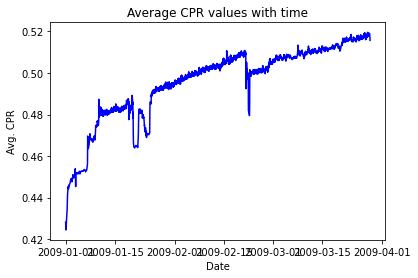

In [64]:
#Plotting the CPRAVG data
plt.title('Average CPR values with time')
plt.xlabel('Date')
plt.ylabel('Avg. CPR')
plt.plot(df['CPRAVG'],color = 'blue')

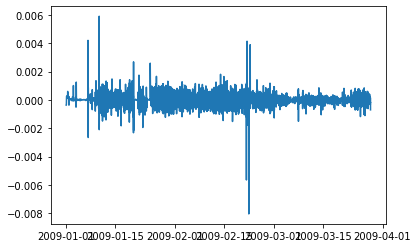

In [65]:
#Differencing the data.
diff_df = df['CPRAVG'].diff().dropna()
plt.plot(diff_df)

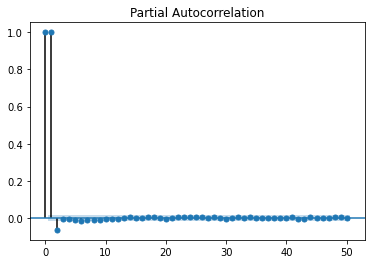

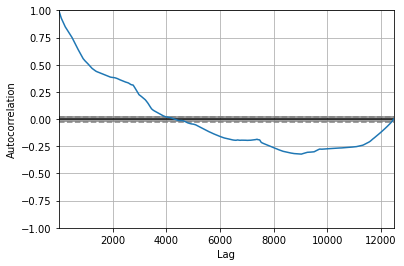

P-value for the original data is 0.002488.


In [66]:
plot_pacf(df['CPRAVG'],lags = 50)
plt.show()
autocorrelation_plot(df['CPRAVG'])
plt.show()
res = adfuller(df['CPRAVG'])
res_diff = adfuller(diff_df)
print("P-value for the original data is %f."%res[1]) 


As our P-value is less than 0.05, there is no need for differencing.

Now we will create our ARIMAX model. Note that we do not have seasonal data. So we shall remove the seasonal_order parameter from our method, and we are good to go!

In [67]:
#Printing list of columns:
cols = list(df)[0:df.shape[1]]
print(cols)

['CPRAVG', 'PROP', 'BUT', 'FLW', 'COT', 'TEMP', 'PRESS', 'DRAFT', 'ETH']


In [77]:
#Splitting the data:
split_length = 0.8
train_df = df[0:int(split_length*df.shape[0])]
val_df = df[int(split_length*df.shape[0]):df.shape[0]]
print(val_df)

                       CPRAVG       PROP  ...     DRAFT        ETH
Date Time                                 ...                     
2009-03-11 06:30:00  0.510380  25.304581  ... -4.388204  68.614899
2009-03-11 06:40:00  0.510578  25.327841  ... -4.423697  68.658592
2009-03-11 06:50:00  0.510695  25.248211  ... -4.427844  69.108223
2009-03-11 07:00:00  0.510778  25.329109  ... -4.407438  68.647850
2009-03-11 07:10:00  0.510631  24.965330  ... -4.412057  69.346764
...                       ...        ...  ...       ...        ...
2009-03-28 13:20:00  0.516947  22.566521  ... -4.964487  72.158081
2009-03-28 13:30:00  0.516790  23.644880  ... -4.957215  71.223877
2009-03-28 13:40:00  0.516591  23.736650  ... -4.961114  70.807220
2009-03-28 13:50:00  0.516339  23.319229  ... -4.955902  71.450020
2009-03-28 14:00:00  0.515635  22.664320  ... -4.967060  72.160553

[2494 rows x 9 columns]


In [69]:
#choosing best parameters
# parameters = arma_order_select_ic(df['CPRAVG'], max_ar=7, max_ma=7, ic='aic', trend='c')
# print('ARMA (p,q) = ',parameters['aic_min_order'],'is the best.')

In [110]:
#Creating ARIMAX model:
d = 0
p = 7
q = 5
#Creating the exog dataframe
arimax_model = SARIMAX(train_df['CPRAVG'], order = (p,d,q), exog = train_df[['PROP', 'BUT', 'FLW', 'COT', 'TEMP', 'PRESS', 'DRAFT', 'ETH']])

# import pmdarima as pm
# arimax_model = pm.auto_arima(train_df['CPRAVG'], 
#                              exogenous = train_df[['PROP', 'BUT', 'FLW', 'COT', 'TEMP', 'PRESS', 'DRAFT', 'ETH']],
#                              start_p = 1,
#                              start_q = 1,
#                              max_p=3,
#                              max_q=3, 
#                              test='adf',
#                              suppress_warnings=True, 
#                              seasonal=False,
#                              m = 1,
#                              d = None,
#                              stepwise = True)
# arimax_model.summary()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  % freq, ValueWarning)


Model has been created! Let's fit it.

In [111]:
res = arimax_model.fit(disp = False,
                       maxiter = 50)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Once that is done, we shall have a look at the model summary.

In [112]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 CPRAVG   No. Observations:                 9974
Model:               SARIMAX(7, 0, 5)   Log Likelihood               -5897.069
Date:                Mon, 02 Aug 2021   AIC                          11836.139
Time:                        08:37:53   BIC                          11987.501
Sample:                    01-01-2009   HQIC                         11887.381
                         - 03-11-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PROP           0.0015   8.68e-06    170.638      0.000       0.001       0.001
BUT           -0.0152   1.69e-05   -894.922      0.000      -0.015      -0.015
FLW        -6.903e-06   9.76e-09   -707.424      0.000   -6.92e-06   -6.88e-06
COT            0.0006   2.63e-06    221.046      0.000       0.001       0.001
TEMP           0.0004   3.09e-06    133.100      0.000       0.000       0.000
PRESS          0.0278      0.001     26.193      0.000       0.026       0.030
DRAFT         -0.0074   3.12e-05   -237.741      0.000      -0.007      -0.007
ETH           -0.0013    8.2e-06   -156.076      0.000      -0.001      -0.001
ar.L1              -0      0.001         -0      1.000      -0.002       0.002
ar.L2              -0      0.001         -0      1.000      -0.002       0.002
ar.L3              -0      0.001         -0      1.000      -0.002       0.002
ar.L4              -0      0.001         -0      1.000      -0.002       0.002
ar.L5              -0      0.001         -0      1.000      -0.002       0.002
ar.L6              -0      0.002         -0      1.000      -0.005       0.005
ar.L7               0      0.002          0      1.000      -0.004       0.004
ma.L1               0      0.001          0      1.000      -0.002       0.002
ma.L2               0      0.001          0      1.000      -0.002       0.002
ma.L3               0      0.001          0      1.000      -0.002       0.002
ma.L4               0      0.001          0      1.000      -0.002       0.002
ma.L5              -0      0.001         -0      1.000      -0.002       0.002
sigma2      7.306e-06   2.68e-08    272.748      0.000    7.25e-06    7.36e-06
===================================================================================
Ljung-Box (L1) (Q):                8888.83   Jarque-Bera (JB):               415.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.65e+17. Standard errors may be unstable.
"""

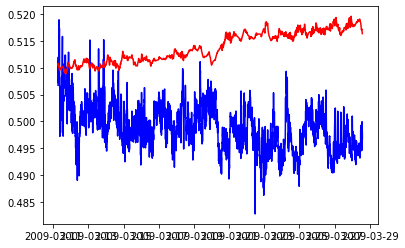

In [113]:
# forecast = arimax_model.predict(n_periods=val_df.shape[0], dynamic = True, exogenous = val_df[['PROP', 'BUT', 'FLW', 'COT', 'TEMP', 'PRESS', 'DRAFT', 'ETH']])
start = train_df.shape[0]
end = df.shape[0] - 1
forecast = res.predict(start = start, end = end, dynamic = True, exog = val_df[['PROP', 'BUT', 'FLW', 'COT', 'TEMP', 'PRESS', 'DRAFT', 'ETH']])
plt.plot(forecast, color = 'blue')
plt.plot(df['CPRAVG'][start:end], color = 'red')